In [1]:
import os
from os import path
import glob
import pickle
import gc
import json
import csv

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from datasets import *

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', 150)

# 인코더 부분 (완료시 사용하지 않는 란)

In [ ]:
# 데이터 파일 목록 가져오기
file_list = glob.glob("data/*.csv")

# 삭제할 컬럼 목록
columns_to_drop = ["device_carrier", "platform", "os_version", "device_type"]

# LabelEncoder 초기화
encoders = {}

# 변환된 데이터를 저장할 CSV 파일
encoded_file = "./lwc_encoder/merged_encoded_data.csv"

# 기존 파일 불러오기
if os.path.exists(encoded_file):
    existing_df = pd.read_csv(encoded_file)
    all_columns = set(existing_df.columns)
else:
    existing_df = pd.DataFrame()
    all_columns = set()

# 기존 LabelEncoder 불러오기 (있다면)
encoder_file = "./lwc_encoder/label_encoders.pkl"
if os.path.exists(encoder_file):
    with open(encoder_file, "rb") as f:
        encoders = pickle.load(f)

# 새로운 데이터를 저장할 리스트
new_data_list = []

# 모든 파일 처리
for file in file_list:
    for chunk in pd.read_csv(file, chunksize=100000):
        chunk.drop(columns=columns_to_drop, errors="ignore", inplace=True)

        # 새로운 컬럼이 있으면 추가
        new_columns = set(chunk.columns) - all_columns
        if new_columns:
            # print(f"새로운 컬럼 발견: {new_columns}")
            all_columns.update(new_columns)

        # 인코딩할 컬럼 선택 (문자열 컬럼 중 삭제하지 않은 컬럼)
        all_string_columns = chunk.select_dtypes(include=["object"]).columns.tolist()
        columns_to_encode = [col for col in all_string_columns if col not in columns_to_drop and col != "client_event_time"]

        # 새로 발견된 문자열 컬럼에 대해 LabelEncoder 추가
        for col in columns_to_encode:
            if col not in encoders:
                encoders[col] = LabelEncoder()
                encoders[col].fit(chunk[col].astype(str).fillna(""))
            else:
                # 새로운 값이 있을 경우 기존 LabelEncoder 업데이트
                new_values = set(chunk[col].astype(str).fillna("").unique()) - set(encoders[col].classes_)
                if new_values:
                    # print(f"🔄 새로운 값 추가됨 ({col}): {new_values}")
                    updated_classes = np.append(encoders[col].classes_, list(new_values))
                    encoders[col].fit(updated_classes)  # 새 값 포함하여 다시 학습

        # Label Encoding 적용
        for col in columns_to_encode:
            chunk[col] = chunk[col].astype(str).fillna("")
            chunk[col] = encoders[col].transform(chunk[col])

        # 기존 데이터와 컬럼을 맞춤 (새로운 컬럼이 추가되면 NaN으로 채움)
        chunk = chunk.reindex(columns=all_columns, fill_value=np.nan)

        # 리스트에 추가
        new_data_list.append(chunk)

        del chunk
        gc.collect()

# 새로운 데이터프레임 병합
new_data_df = pd.concat([existing_df] + new_data_list, ignore_index=True)

# 정리된 데이터를 CSV로 저장
new_data_df.to_csv(encoded_file, index=False, sep=",", quoting=csv.QUOTE_MINIMAL)

print(f"업데이트 완료, 저장됨: {encoded_file}")

# 인코딩 맵핑 저장 (디코딩을 쉽게 하기 위해)
encoding_map = {col: {label: idx for idx, label in enumerate(encoders[col].classes_)} for col in encoders}

with open("./lwc_encoder/encoding_map.json", "w", encoding="utf-8") as f:
    json.dump(encoding_map, f, ensure_ascii=False, indent=4)

# 인코더 저장 (디코딩용)
with open(encoder_file, "wb") as f:
    pickle.dump(encoders, f)

print("인코딩 및 저장 완료 ✅")

C:\Users\lento\AppData\Local\Temp\ipykernel_26568\3439702640.py:32: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=100000):
C:\Users\lento\AppData\Local\Temp\ipykernel_26568\3439702640.py:32: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=100000):
C:\Users\lento\AppData\Local\Temp\ipykernel_26568\3439702640.py:32: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=100000):
C:\Users\lento\AppData\Local\Temp\ipykernel_26568\3439702640.py:32: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file, chunksize=100000):
C:\Users\lento\AppData\Local\Temp\ipykernel_26568\3439702640.py:32: DtypeWarning: Columns (13) have mixed types. Spe

업데이트 완료, 저장됨: ./lwc_encoder/merged_encoded_data.csv
인코딩 및 저장 완료 ✅


# 인코더 데이터 로드

In [ ]:
total_df = pd.read_csv('./lwc_encoder/merged_encoded_data.csv')

C:\Users\lento\AppData\Local\Temp\ipykernel_11268\67430114.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  total_df = pd.read_csv('./lwc_encoder/merged_encoded_data.csv')


Series([], Name: count, dtype: int64)

# 디코더 파일 불러오기 및 디코더 함수 정의

# AARRR Framework 지표 내용

## Acquisition

| 지표 | 정의 | 계산식 |
|------|------|------|
| **신규 사용자 수 (NU, New User)** | 특정 서비스에 방문한 이력이 없는 상태에서, 처음 방문하거나 상호작용한 사용자의 수 | - |
| **회원 가입 수 (Sign Up)** | 특정 서비스에 회원 가입한 사용자의 수 | - |
| **앱 다운로드 수 (App Installs)** | 특정 앱(어플리케이션)을 다운로드한 수 | - |
| **리드 수 (Leads)** | 일정 수준의 정보를 제공하는 잠재 고객, 혹은 고객 정보 그 자체의 수 | - |
| **고객 획득 비용 (CAC, Customer Acquisition Cost)** | 신규 고객 1명을 획득하기 위해 필요한 비용 | **블렌디드 CAC** : 고객 획득을 위해 투입한 전체 금액 / 획득한 전체 고객 수 <br> **매체별 CAC** : 특정 광고 매체에서 고객 획득을 위해 투입한 금액 / 해당 매체에서 획득한 고객 수 |
| **(광고) 클릭률 (CTR, Click-Through Rate)** | 광고에 노출된 사용자 중에, 광고를 클릭한 사용자의 비율 | (광고 클릭 수 / 광고 노출 수) * 100 |
| **(광고) 조회율 (VTR, View-Through Rate)** | 영상 광고에 노출된 사용자 중에, 영상을 조회한 사용자의 비율 | (광고 조회 수 / 광고 노출 수) * 100 |
| **(광고) 전환율 (CVR, Conversion Rate)** | 광고를 클릭하여 유입된 사용자 중에, 주요한 전환 행동을 한 사용자의 비율 | (전환 수 / 광고 클릭 수) * 100 |
| **CPM (Cost-Per-Mille)** | 광고 1,000번 노출당 비용 | (총 광고 비용 / 광고 노출 수) * 1000 |
| **CPC (Cost-Per-Click)** | 광고 클릭당 비용 | 총 광고 비용 / 광고 클릭 수 |
| **CPV (Cost-Per-View)** | 영상 광고 조회당 비용 | 총 광고 비용 / 광고 조회 수 |
| **CPA (Cost-Per-Action)** | 특정 액션(회원가입, 상품 구매, 이벤트 참여 등)당 비용 | 총 광고 비용 / 특정 액션이 발생한 수 |
| **CPI (Cost-Per-Install)** | 앱 설치당 비용 | 총 광고 비용 / 앱 설치 수 |

## Activation

| 지표 | 정의 | 계산식 |
|------|------|------|
| **체류 시간 (DT, Duration Time)** | 사용자가 특정 서비스에 머무른 시간 | **평균 체류 시간** = 총 체류 시간(사용자들이 방문하여 머무른 전체 시간) / 방문한 전체 사용자 수 |
| **평균 페이지 체류 시간 (Average Time on Page)** | 사용자가 서비스 내의 단일 페이지에서 머무른 평균 시간 | 단일 페이지의 총 체류 시간 / 해당 페이지를 방문한 사용자 수 |
| **평균 세션 시간 (Average Session Duration)** | 단일 세션 동안 사용자가 특정 서비스에서 머무른 평균 시간 | 총 세션 시간(각 세션의 ‘세션 종료 시각 - 세션 시작 시각’의 총합) / 세션 수 |
| **페이지 뷰 (PV, Page View)** | 특정 웹사이트나 서비스를 방문하여 열람한 페이지의 수 (중복 포함) | - |
| **순 방문자 수 (UV, Unique Visitor)** | 특정 웹사이트나 서비스에 방문한 사용자 중 중복되는 사용자를 배제한 순 방문자 수 | - |
| **페이지 이탈률 (Bounce Rate, 반송률)** | 웹이나 앱에서 첫 페이지만 조회한 후, 추가적인 행동이나 상호작용 없이 바로 이탈한 사용자의 비율 | (반송 수 / 방문 수) * 100 <br> *반송 수 : 랜딩 페이지에 방문하여 1PV만을 발생시킨 방문의 수* |
| **Aha-moment 전환율** | Aha-moment를 경험하는 사용자의 비율 | (Aha-moment를 경험한 사용자 수 / 전체 사용자 수) * 100 |
| **구매 전환율 / 구독 전환율** | 전체 방문자 중 구매/구독을 한 사용자의 비율 | (구매 수 or 구독 수 / 방문 수) * 100 |
| **세부 퍼널 단계별 전환율** | 세부 퍼널(Aha-moment 퍼널, 구매 퍼널, 구독 퍼널 등) 안에서의 단계별 전환율 | (이후 단계로 전환된 수 / 이전 단계의 수) * 100 |

## Retention

| 지표 | 정의 | 계산식 |
|------|------|------|
| **유지율 (Retention Rate, 잔존율)** | 사용자가 유지되는 비율 | (유지된 사용자 수 / 기존 사용자 수) * 100 |
| **이탈률 (Churn Rate)** | 사용자가 이탈하는 비율 | (이탈한 사용자 수 / 기존 사용자 수) * 100 |
| **재구매율 / 재구독률** | 첫 구매후 특정 단위 기간(1주, 1개월, 3개월 등)내에 다시 구매/구독하는 사용자의 비율 | (재구매 or 재구독한 사용자 수 / 기존 사용자 수) * 100 |
| **사용자 고착도 (Stickiness)** | 사용자가 서비스에 계속해서 방문하는 정도 | DAU(일간 활성 사용자 수) / MAU(월간 활성 사용자 수) * 100 |
| **활성 사용자 수 (AU, Active User)** | 특정 웹사이트, 앱 또는 플랫폼과 상호작용하며 활성화된 사용자 수 (중복 제거) | - |
| **기간별 활성 사용자 수** | 특정 기간 동안 활성 사용자 수 (HAU, DAU, WAU, MAU) | **HAU** : 시간당 활성 사용자 수 <br> **DAU** : 일간 활성 사용자 수 <br> **WAU** : 주간 활성 사용자 수 <br> **MAU** : 월간 활성 사용자 수 |

## Revenue

| 지표 | 정의 | 계산식 |
|------|------|------|
| **매출 (Revenue)** | 비즈니스가 고객에게 상품 혹은 서비스를 판매하여 창출하는 총 금액으로, 비즈니스 운영과 관련된 비용을 공제하기 전의 금액 | - |
| **매출총이익 (Gross Profit, 마진)** | 매출액에서 매출원가(COGS, 제품이나 서비스를 제공하는 데 드는 직접 비용)를 차감한 금액 | 매출 - 매출 원가 |
| **매출총이익률 (Gross Profit Margin, 마진율)** | 매출 대비 매출총이익(마진)의 비율 | {(매출 - 매출 원가) / 매출} * 100 |
| **순이익 (Net Profit, Net Income)** | 매출에서 매출 원가, 인건비, 광고비, 세금 등 비즈니스가 사용한 모든 비용을 차감하고 영업외수익과 비용까지 고려한 뒤 남은 금액으로, 비즈니스의 순수한 이익 | 매출 - 매출 원가 - 판매관리비 + (금융수익 - 금융비용) + (영업외수익 - 영업외비용) - 법인세비용 |
| **MRR (Monthly Recurring Revenue, 월간 반복 매출)** | 매월 반복적으로 발생하는 매출 | 기존 고객의 월간 매출(전월 매출) - 이탈 고객의 월간 기여 매출 + 신규/부활 고객의 월간 매출 + 플랜 업그레이드/다운그레이드로 인한 월간 매출 차액 |
| **ARR (Annual Recurring Revenue, 연간 반복 매출)** | 매년 반복적으로 발생하는 매출 | 기존 고객의 연간 매출(전년도 매출) - 이탈 고객의 연간 기여 매출 + 신규/부활 고객의 연간 매출 + 플랜 업그레이드/다운그레이드에 따른 연간 매출 차액 |
| **ROI (Return on Investment, 투자 수익률)** | 투자 비용(광고비를 포함한 모든 비용) 대비 수익률(순이익 기준) | (순이익 / 전체 투자 비용) * 100 |
| **ROAS (Return on Ad Spend, 광고 수익률)** | 투입한 광고 비용 대비 수익률(매출 기준) | (광고 캠페인을 통해 발생한 매출 / 투입한 총 광고 비용) * 100 <br> **매체별 ROAS** : (특정 광고 매체에서 발생한 매출 / 해당 매체에 투입한 총 광고 비용) * 100 |
| **PU (Paying User, 유료 결제 사용자 수)** | 유료 결제를 한 사용자의 수 | - |
| **ARPU (Average Revenue Per User)** | 고객 평균 매출로, 무료 사용자와 유료 결제 사용자를 포함한 전체 사용자 1인당 평균 매출 | 총 매출 / 전체 사용자 수 |
| **ARPPU (Average Revenue per Paying User)** | 유료 고객 평균 매출로, 유료 결제 사용자 1인당 평균 매출 | 총 매출 / 유료 결제 사용자 수 (PU) |
| **ARPDAU (Average Revenue Per Daily Active User)** | DAU(일간 활성 사용자) 1인당 일 평균 매출 | 일 매출 / DAU(일간 활성 사용자 수) |
| **LTR (Lifetime Revenue, 고객 생애 매출)** | 고객 한 명이 제품/서비스를 이용하는 전체 생애 동안 우리 비즈니스에서 발생시킬 것으로 예상되는 기대 매출 | 고객이 생애 동안 누적하여 발생시킨 총 매출의 합 / 고객 수 |
| **LTV (Lifetime Value, 고객 생애 가치)** | 고객 한 명이 제품/서비스를 이용하는 전체 생애 동안 우리 비즈니스에서 발생시킬 것으로 예상되는 기대 가치(순이익 기준) | {평균 구매 금액 * 마진율 * 구매 빈도(구매 횟수) * 고객 수명} - (고객 획득 비용 + 고객 유지 비용) |

## Referral

| 지표 | 정의 | 계산식 |
|------|------|------|
| **바이럴 주기 시간 (Viral Cycle Time)** | 기존 사용자가 친구를 초대하고, 초대받은 친구가 신규 사용자로 유입되기까지 걸리는 시간 | - |
| **바이럴 계수 (Viral Coefficient)** | 기존 사용자 1명당 만들어내는 신규 사용자의 수 | 기존 사용자 1명당 평균 친구 초대 수 * 초대받은 친구의 초대 수락 비율 |
| **NPS (Net Promoter Score, 순 추천 지수)** | 기존 사용자가 제품이나 서비스, 브랜드를 추천할 가능성으로, 고객 충성도를 측정하는 표준 척도 | 추천 그룹의 비율(%) - 비추천 그룹의 비율(%) |
| **SNS 공유 수 (SNS Share Rate)** | 공유 수, 댓글 수, 태그 수 등 | - |

---
# 데이터 EDA
---

## 공통 데이터 : enter.main_page

In [7]:
# 데이터 불러오기
enter_main_page_df = enter.main_page()

# 데이터 확인
enter_main_page_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seongnam-si,2023-04-05 21:55:06.140000,South Korea,NaN,Samsung Phone,Samsung Galaxy S21 5G,enter.main_page,Korean,Whale,1.0.0.0,Web,NaN
1,Dongdaemun-gu,2023-04-05 21:04:28.967000,South Korea,NaN,Mac,Mac,enter.main_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4
2,Hwaseong-si,2023-04-05 21:01:31.258000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
3,Hwaseong-si,2023-04-05 21:02:50.374000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
4,Seoul,2023-04-05 21:30:33.727000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.main_page,Korean,Chrome,112.0.0.0,Web,NaN
5,Sejong,2023-04-05 21:36:02.749000,South Korea,NaN,Apple iPhone,Apple iPhone 12 Mini,enter.main_page,Korean,Instagram,276.1.0.14.103,Web,NaN
6,Seoul,2023-04-05 21:37:37.469000,South Korea,NaN,Samsung SM-S916N,NaN,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
7,Seoul,2023-04-05 21:37:42.563000,South Korea,NaN,Samsung SM-S916N,NaN,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
8,Jung-gu,2023-04-05 21:55:29.031000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
9,Seoul,2023-04-05 21:05:40.020000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,16.4,Web,NaN


In [8]:
# 데이터 총량 확인
enter_main_page_df.shape

(2133548, 12)

In [10]:
# 데이터 info() 확인
enter_main_page_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133548 entries, 0 to 2133547
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   city               object 
 1   client_event_time  object 
 2   country            object 
 3   device_carrier     float64
 4   device_family      object 
 5   device_type        object 
 6   event_type         object 
 7   language           object 
 8   os_name            object 
 9   os_version         object 
 10  platform           object 
 11  user_id            object 
dtypes: float64(1), object(11)
memory usage: 195.3+ MB


In [11]:
# 데이터 결측치 확인
enter_main_page_df.isnull().sum()

city                   56988
client_event_time          0
country                 1869
device_carrier       2133548
device_family           2813
device_type            60050
event_type                 0
language                   0
os_name                 2304
os_version             13868
platform                   0
user_id              1611032
dtype: int64

---
## 1번 : 서비스 무료체험 테이블

---
## 2번 : 콘텐츠 수강 및 후기 버튼 클릭 테이블

---
## 3번 : 회원가입 테이블

---
## 4번 : 결제 진행 테이블

In [20]:
# 데이터 불러오기
enter_payment_page_df = enter.payment_page()
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()
cancel_plan_df = click.cancel_plan_button()

### enter.payment_page
결제 페이지 진입

In [27]:
# 데이터 확인
enter_payment_page_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seoul,2023-04-05 21:31:27.602000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.payment_page,Korean,Chrome,112.0.0.0,Web,8ee58bcaa05b234cdbf84167c0983385
1,Wonju,2023-04-05 21:33:30.699000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Chrome,111.0.0.0,Web,74d17c27a41656e7788b0c81d9f76cda
2,Daejeon,2023-04-05 21:05:28.337000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Edge,111.0.1661.62,Web,62cfa08370da60b8db4495baaff62806
3,Seoul,2023-04-05 21:45:27.935000,South Korea,NaN,Mac,Mac,enter.payment_page,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce
4,Seoul,2023-04-05 21:46:50.632000,South Korea,NaN,Mac,Mac,enter.payment_page,Korean,Safari,15.6.1,Web,06b6868000a5d576180aca47896d6cce
5,Gwanak-gu,2023-04-10 14:55:31.376000,South Korea,NaN,Samsung Galaxy Phone,Samsung Galaxy A31,enter.payment_page,Korean,Chrome,111.0.0.0,Web,37f5dcfad7488c70d6657a69a0384be3
6,Seoul,2023-04-10 14:56:21.536000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.payment_page,Korean,Mobile Safari,16.3,Web,f693a50e45b6aa18fb6b0c91beee8ea1
7,Seoul,2023-04-10 14:56:26.141000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.payment_page,Korean,Mobile Safari,16.3,Web,f693a50e45b6aa18fb6b0c91beee8ea1
8,Buk-gu,2023-04-10 14:03:05.287000,South Korea,NaN,Windows,Windows,enter.payment_page,Korean,Chrome,112.0.0.0,Web,9cf14379b941964d78b7c7914c573b2f
9,Gimpo-si,2023-04-10 14:44:31.251000,South Korea,NaN,Samsung Phone,Samsung Galaxy A53 5G,enter.payment_page,Korean,Chrome WebView,111.0.5563.116,Web,583457ca80cd98524fda28b54181ded6


In [26]:
# 데이터 크기 확인
enter_payment_page_df.shape

(158834, 12)

In [21]:
# 데이터 인포 확인
enter_payment_page_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165061 entries, 0 to 165060
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   city               162362 non-null  object 
 1   client_event_time  165061 non-null  object 
 2   country            164899 non-null  object 
 3   device_carrier     0 non-null       float64
 4   device_family      165060 non-null  object 
 5   device_type        159066 non-null  object 
 6   event_type         165061 non-null  object 
 7   language           165061 non-null  object 
 8   os_name            165061 non-null  object 
 9   os_version         164560 non-null  object 
 10  platform           165061 non-null  object 
 11  user_id            158834 non-null  object 
dtypes: float64(1), object(11)
memory usage: 15.1+ MB


In [22]:
# 데이터 결측치 확인
enter_payment_page_df.isnull().sum()

city                   2699
client_event_time         0
country                 162
device_carrier       165061
device_family             1
device_type            5995
event_type                0
language                  0
os_name                   0
os_version              501
platform                  0
user_id                6227
dtype: int64

- 유심히 봐야할 결측치로 user_id를 선정 (이 이벤트의 주체는 유저)
- user_id의 결측치가 발생한 것으로 보았을 때, 비회원인 상태에서 결제 페이지를 진입한 것으로 확인
- 추측 : 페이지 내의 스크립트로 로그인이 필요하다는 alert를 보낸 후 로그인 창으로 돌아가는 방식으로 진행했을 것

따라서 회원인 데이터를 기준으로 사용하는 것이 마땅하다고 판단하여 user_id에 결측치가 나온 값은 제거처리

In [23]:
# user_id 내 결측치 제거
enter_payment_page_df = enter_payment_page_df.dropna(subset=['user_id'])

### complete.subscription
첫 결제 완료

In [28]:
# 데이터 확인
complete_subscription_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Nowon-gu,2023-04-05 21:40:04.000000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Edge,111.0.1661.62,Web,1116a2ae90ca6b06f85feba27ad51ef0,15920,15920,0,NaN
1,Seoul,2023-04-10 14:20:03.008000,South Korea,NaN,Apple iPhone,Apple iPhone,complete.subscription,Korean,Mobile Safari,16.3,Web,c0f5678df8967163e6e2c464ed006791,131600,131600,0,NaN
2,Yangsan,2023-03-12 08:46:14.026000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,79421b5d038205ad7adbb1e2c3b89741,131600,119756,11844,NaN
3,Geumjeong-gu,2023-04-12 11:35:01.865000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,bdffe1f18684704d4ea2d7eebcaed180,131600,131600,0,NaN
4,Gwangmyeong,2023-05-31 01:25:55.820000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,113.0.0.0,Web,d4f54ecf6c4d7bf8742f80505f02d6dc,15920,15920,0,NaN
5,Seocho-gu,2023-05-31 01:27:05.914000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,113.0.0.0,Web,ac7c3298f6afc990333b9dbf937f2378,15920,15920,0,NaN
6,Gyeonggi-do,2023-01-31 14:44:19.644000,South Korea,NaN,Samsung Phone,Samsung Galaxy S21+ 5G,complete.subscription,Korean,Samsung Browser,19.0,Web,81cedbb74a6400b881a77694831102d9,95200,95200,0,NaN
7,Sangju,2023-01-31 14:27:53.465000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,109.0.0.0,Web,db0e90b2ae46d565e7f182d5202b8737,95200,95200,0,NaN
8,Gangnam-gu,2023-01-31 14:24:46.377000,South Korea,NaN,Samsung Phone,Samsung Galaxy S22,complete.subscription,Korean,Chrome WebView,108.0.5359.128,Web,4a267eba2e65ee24be66c3da88316f20,95200,95200,0,NaN
9,Songpa-gu,2023-01-31 14:10:20.700000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,109.0.0.0,Web,99a9f26d820203528cfd7cb0bfce0e2a,95200,95200,0,NaN


In [29]:
# 데이터 크기 확인
complete_subscription_df.shape

(14289, 16)

In [24]:
# 데이터 인포 확인
complete_subscription_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14289 entries, 0 to 14288
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    13757 non-null  object 
 1   client_event_time       14289 non-null  object 
 2   country                 13906 non-null  object 
 3   device_carrier          0 non-null      float64
 4   device_family           13914 non-null  object 
 5   device_type             13764 non-null  object 
 6   event_type              14289 non-null  object 
 7   language                13914 non-null  object 
 8   os_name                 13908 non-null  object 
 9   os_version              13899 non-null  object 
 10  platform                13914 non-null  object 
 11  user_id                 14289 non-null  object 
 12  plan.price              14289 non-null  int64  
 13  paid_amount             14289 non-null  int64  
 14  coupon.discount_amount  14289 non-null

In [25]:
# 데이터 결측치 확인
complete_subscription_df.isnull().sum()

city                        532
client_event_time             0
country                     383
device_carrier            14289
device_family               375
device_type                 525
event_type                    0
language                    375
os_name                     381
os_version                  390
platform                    375
user_id                       0
plan.price                    0
paid_amount                   0
coupon.discount_amount        0
pg.type                   12647
dtype: int64

- user_id의 결측치가 발생하지 않았다.
- 따로 결측치를 처리를 해야할 부분은 데이터를 어떠한 분석으로 진행을 할지에 대해서 각 컬럼의 결측치가 문제가 되는지 확인하고 결측치 처리할 것.


### renew.subscription
정기 결제 완료

In [30]:
# 데이터 확인
renew_subscription_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Nam-gu,2022-09-08 03:05:02.068,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Edge,104,Web,6ddea3af2eaae869861c1190dcc9d4a3,15920,15920,0,NaN
1,Nam-gu,2022-09-08 03:40:02.050,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,c2d47034960fdff5df495822ff66fbc1,15920,15920,0,NaN
2,Dongjak-gu,2022-09-08 03:49:00.829,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,de91f1226dd938990fefc79545daf468,42960,40812,2148,NaN
3,Yongin-si,2022-09-08 04:10:06.406,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,bf14840a8cb4643e6d557da96e35a3af,15920,15920,0,NaN
4,Dongjak-gu,2022-09-08 04:40:01.895,South Korea,NaN,Android,Android,renew.subscription,Korean,Chrome Mobile,103,Web,7ddc1c2990d0645d82885394e3c518b5,15920,15920,0,NaN
5,Yangcheon-gu,2022-09-08 05:10:01.955,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,85822a1663cebc3351e24c25f8c02552,15920,7960,7960,NaN
6,Dongdaemun-gu,2022-09-08 06:45:01.589,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,104,Web,47a7b82262e14f30c6ee06a314004714,15920,15920,0,NaN
7,Gangnam-gu,2022-09-08 06:45:05.980,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,102,Web,d8e3205c18c9e436e37994dadd604a73,15920,15920,0,NaN
8,Gangwon-do,2022-09-08 06:47:02.016,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,105,Web,cce04d49260614dcb65b3f3bde7cc4b6,15920,14487,1433,NaN
9,Buk-gu,2022-09-08 07:15:01.004,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,105,Web,19e512a7f43998e40ef164887b5a55bc,42960,42960,0,NaN


In [31]:
# 데이터 크기 확인
renew_subscription_df.shape

(15945, 16)

In [32]:
# 데이터 인포 확인
renew_subscription_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15945 entries, 0 to 15944
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    15575 non-null  object 
 1   client_event_time       15945 non-null  object 
 2   country                 15656 non-null  object 
 3   device_carrier          0 non-null      float64
 4   device_family           15657 non-null  object 
 5   device_type             15484 non-null  object 
 6   event_type              15945 non-null  object 
 7   language                15657 non-null  object 
 8   os_name                 15654 non-null  object 
 9   os_version              15644 non-null  object 
 10  platform                15657 non-null  object 
 11  user_id                 15945 non-null  object 
 12  plan.price              15945 non-null  int64  
 13  paid_amount             15945 non-null  int64  
 14  coupon.discount_amount  15945 non-null

In [33]:
# 데이터 결측치 확인
renew_subscription_df.isnull().sum()

city                        370
client_event_time             0
country                     289
device_carrier            15945
device_family               288
device_type                 461
event_type                    0
language                    288
os_name                     291
os_version                  301
platform                    288
user_id                       0
plan.price                    0
paid_amount                   0
coupon.discount_amount        0
pg.type                   13213
dtype: int64

### resubscribe.subscription
만료 후 재구독 완료

In [34]:
# 데이터 확인
resubscribe_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Daejeon,2023-04-05 21:11:45.525,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Edge,111.0.1661.62,Web,41362ad5ebcade2bb1b78344a53e7ccf,15920,15920,0,NaN
1,Seoul,2023-06-30 09:59:56.848,South Korea,NaN,Samsung Phone,Samsung Galaxy S22+,resubscribe.subscription,Korean,Chrome WebView,113.0.5672.162,Web,68831c27e47f0e8f04ba809baeec218e,15920,15920,0,NaN
2,Nowon-gu,2023-06-13 06:20:22.524,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,114.0.0.0,Web,4e7568cb7db01f8386614ec2c6c961cd,15920,15920,0,NaN
3,Suwon,2023-06-11 11:02:11.878,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,114.0.0.0,Web,f91f19527b9ec688e028ec884b1b5c1c,131600,131600,0,NaN
4,Koishikawa,2023-06-13 14:39:25.736,Japan,NaN,Apple iPhone,Apple iPhone,resubscribe.subscription,Japanese,Chrome,114.0.5735.99,Web,2276d7d2a31e05f4a5558c6406cc36c9,131600,131600,0,NaN
5,Toronto,2023-06-15 12:01:12.785,Canada,NaN,Apple iPhone,Apple iPhone,resubscribe.subscription,English,Mobile Safari,16.5,Web,e2652bbc8ce6ef935dc655ed9b3a1464,15920,15920,0,NaN
6,Seoul,2023-04-16 07:59:10.131,South Korea,NaN,Mac,Mac,resubscribe.subscription,English,Chrome,112.0.0.0,Web,b3d0d86a522f0e4e22579c3d3350ab22,15920,15920,0,NaN
7,Yongsan-gu,2023-06-01 03:11:24.477,South Korea,NaN,Windows,Windows,resubscribe.subscription,Korean,Chrome,113.0.0.0,Web,dfec4d0678f6d3824d6a1923b25a75de,15920,15920,0,NaN
8,Seoul,2023-05-30 08:36:16.951,South Korea,NaN,Mac,Mac,resubscribe.subscription,Korean,Chrome,112.0.0.0,Web,0b342edb20f16f8666d3df5a164de117,15920,15920,0,NaN
9,Tangjin,2023-05-16 15:11:53.790,South Korea,NaN,Mac,Mac,resubscribe.subscription,Korean,Chrome,97,Web,ca2976a5fc27e353fc1e17e21d5848ec,15920,15920,0,NaN


In [36]:
# 데이터 크기 확인
resubscribe_df.shape

(791, 16)

In [35]:
# 데이터 인포 확인
resubscribe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791 entries, 0 to 790
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    775 non-null    object 
 1   client_event_time       791 non-null    object 
 2   country                 784 non-null    object 
 3   device_carrier          0 non-null      float64
 4   device_family           784 non-null    object 
 5   device_type             773 non-null    object 
 6   event_type              791 non-null    object 
 7   language                784 non-null    object 
 8   os_name                 784 non-null    object 
 9   os_version              784 non-null    object 
 10  platform                784 non-null    object 
 11  user_id                 791 non-null    object 
 12  plan.price              791 non-null    int64  
 13  paid_amount             791 non-null    int64  
 14  coupon.discount_amount  791 non-null    in

In [37]:
# 데이터 결측치 확인
resubscribe_df.isnull().sum()

city                       16
client_event_time           0
country                     7
device_carrier            791
device_family               7
device_type                18
event_type                  0
language                    7
os_name                     7
os_version                  7
platform                    7
user_id                     0
plan.price                  0
paid_amount                 0
coupon.discount_amount      0
pg.type                   618
dtype: int64

### click.cancel_plan_button
구독 취소 버튼 클릭

In [38]:
# 데이터 확인
cancel_plan_df.head(10)

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Daegu,2023-04-10 14:57:48.556,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,111.0.0.0,Web,9e59ecf9a8fbe9051bd0d54f4b702f30
1,Seoul,2023-03-12 08:26:16.224,South Korea,NaN,Apple iPad,Apple iPad,click.cancel_plan_button,English,Mobile Safari,16.3,Web,4ed4d8f12c45504a148bfff0f2e9466e
2,Uijeongbu-si,2023-03-12 08:23:04.955,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,110.0.0.0,Web,b6a1bba3cc4139d7dc821561319221e6
3,Dobong-gu,2023-03-12 08:32:39.271,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,110.0.0.0,Web,40acc1ddfc012f3d2f58a3de95e9e748
4,Geumjeong-gu,2023-04-12 11:36:28.311,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,111.0.0.0,Web,bdffe1f18684704d4ea2d7eebcaed180
5,Incheon,2023-04-12 11:42:20.856,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,112.0.0.0,Web,11b44eae717f4293b283315d2fb49fce
6,Mapo-gu,2023-05-31 01:48:19.226,South Korea,NaN,Mac,Mac,click.cancel_plan_button,Korean,Chrome,113.0.0.0,Web,8c72048ba0eea7dba25371885fb87c44
7,Suwon,2023-01-31 14:22:45.462,South Korea,NaN,Apple iPhone,Apple iPhone,click.cancel_plan_button,Korean,Mobile Safari,16.0,Web,c002b8d46a8e4f3a840c455e50245786
8,Songpa-gu,2023-01-31 14:59:26.869,South Korea,NaN,Windows,Windows,click.cancel_plan_button,Korean,Chrome,109.0.0.0,Web,c58a141f0455c92fba272f453a90dda5
9,Seoul,2023-01-31 14:00:32.016,South Korea,NaN,Apple iPhone,Apple iPhone,click.cancel_plan_button,Korean,Mobile Safari,16.2,Web,805f45812f9c4b6b4081477b23c6180c


In [39]:
# 데이터 크기 확인
cancel_plan_df.shape

(17895, 12)

In [40]:
# 데이터 인포 확인
cancel_plan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17895 entries, 0 to 17894
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               17742 non-null  object 
 1   client_event_time  17895 non-null  object 
 2   country            17893 non-null  object 
 3   device_carrier     0 non-null      float64
 4   device_family      17895 non-null  object 
 5   device_type        17567 non-null  object 
 6   event_type         17895 non-null  object 
 7   language           17895 non-null  object 
 8   os_name            17895 non-null  object 
 9   os_version         17892 non-null  object 
 10  platform           17895 non-null  object 
 11  user_id            16853 non-null  object 
dtypes: float64(1), object(11)
memory usage: 1.6+ MB


In [41]:
# 데이터 결측치 확인
cancel_plan_df.isnull().sum()

city                   153
client_event_time        0
country                  2
device_carrier       17895
device_family            0
device_type            328
event_type               0
language                 0
os_name                  0
os_version               3
platform                 0
user_id               1042
dtype: int64

user_id에서 결측치가 발견되었고 결측치를 제거하여 분석에 사용하면 되지만, 다음과 같은 생각이 들어서 분석을 좀 더 해보았다.

- 모바일의 경우, 앱을 재부팅할 시 로그인이 풀리는 모습을 종종 볼 수 있었다.
- 웹의 경우, 모종의 사유로 로그인이 풀리는 모습을 종종 볼 수 있었다.

다음과 같은 생각으로 user_id가 na인 값인 컬럼 중 os 데이터를 면밀하게 살펴보았다.

In [45]:
cancel_plan_df[cancel_plan_df['user_id'].isnull()]['os_name'].value_counts()

os_name
Chrome             608
Mobile Safari      119
Edge                95
Whale               88
Samsung Browser     46
WebKit              27
Safari              25
Chrome WebView      25
Firefox              6
Instagram            2
GSA                  1
Name: count, dtype: int64

Chrome이 가장 압도적인 숫자로 많이 존재하지만, 그 밑으로 Modile Safari, Samsung Browser인 경우를 보아 다음과 같은 예상을 할 수 있다.

- 모바일에서 페이지 처리 중 가장 큰 오류값을 가질 가능성이 보이고 있다.

---
### 작업란

#### 재구독률

설명 : 첫 구매 후 특정 단위 기간(1주, 1개월, 3개월 등)내에 다시 구매/구독하는 사용자의 비율<br/>
계산 : 각 첫 구매한 이후 다음 구매까지 걸린 시간을 계산하여 그 값을 범위화 시킨 후 그래프 표시

In [55]:
# 데이터 타입 변환
complete_subscription_df['client_event_time'] = pd.to_datetime(complete_subscription_df['client_event_time'])

In [ ]:
# complete.subscription은 유저가 기업 내에서 제공하는 모든 서비스 상품을 첫 구매한 이력
complete_subscription_df['user_id'].value_counts()

user_id
3767d4c7a827422fccf61d45ae889669    8
f833cca4c382ac8c502c6f99bc432725    6
ccea16701cf72a9027d7d5f2c3d3019c    5
e04c24e899b1e875ed432a7b398a4308    4
bdaccf3b8535d78a81114fb5855232c3    3
                                   ..
c8f574f59d5cebdc14b4c103b5e82de0    1
34943b21eda6f814b6566f785ff8a066    1
d2a92dd7e65d264b6bcd8bf6ab2816f2    1
75441a74a656a7e9f7cbd5f6f11b1fff    1
d4f54ecf6c4d7bf8742f80505f02d6dc    1
Name: count, Length: 13881, dtype: int64

하지만 value_counts()를 통해서 확인해보았더니 유저의 count가 1이 아닌 경우를 확인할 수 있었다.<br/>
그래서 각 유저별 groupby를 통해 유저별 결제 시간 내역을 list로 묶은 뒤 걸린 max()-min()값을 통해 시간 차이를 구하여 얼마나 차이가 나는지 확인해보았다.<br/>

_user_id가 8개인 경우도 있는데 이는 왜 안한건지?_<br/>
-> 전체 내용을 훑어봐야 되는 경우가 아니라고 생각.

In [ ]:
# user_id를 기준으로 결제 시간 내역과 결제 횟수, 결제 간격, 결제 금액을 확인
groupby_df = complete_subscription_df.groupby(['user_id']).agg(
    subscription_time=('client_event_time', list), 
    subscription_count=('client_event_time', 'count'),
    time_diff=('client_event_time', lambda x: x.max() - x.min()),
    plan_price=('plan.price', list)
)

In [ ]:
# 결제 횟수가 2번 이상인 값 확인
groupby_df[groupby_df['subscription_count'] > 1]

,subscription_time,subscription_count,time_diff,plan_price
user_id,,,,
018e9f53c73beed1d161a392126d513b,"[2022-03-30 09:59:13.640000, 2022-03-30 04:15:...",2,0 days 05:44:08.635000,"[15920, 15920]"
01ee9c8e8858d201d0ae72cc2757546c,"[2022-10-26 14:45:01.816000, 2022-11-26 14:50:...",2,31 days 00:04:59.962000,"[15920, 15920]"
02a857284f291785a949fbd7ed7d6e91,"[2022-11-08 09:20:01.328000, 2022-11-08 09:20:...",2,0 days 00:00:00.550000,"[42960, 42960]"
046469242e1de011419057a9511925c3,"[2023-05-12 15:43:35.005000, 2023-05-12 13:30:...",2,0 days 02:13:05.256000,"[15920, 131600]"
04e3ed921de9a3cb187256ece5cf81bc,"[2023-06-30 03:03:40.394000, 2023-06-30 01:53:...",2,0 days 01:10:07.496000,"[15920, 15920]"
...,...,...,...,...
fdd65930c3cb37b64725377df0a7b380,"[2022-11-17 06:20:03.725000, 2022-11-17 06:20:...",2,0 days 00:00:00.150000,"[15920, 15920]"
feb2861037f5bb189cc501d05e4126a2,"[2023-08-18 03:05:38.346000, 2023-08-18 04:34:...",2,0 days 01:28:49.733000,"[131600, 15920]"
ff990a16d0f5c8bf914a63b6815ed342,"[2023-01-04 04:55:01.910000, 2023-01-02 16:28:...",2,1 days 12:26:33.771000,"[15920, 83200]"


- 결과값을 통해 각 플랜마다 첫 구매를 한 이력으로 이해할 수 있었다.
- <ins>첫 결제가 중복인 경우는 첫 결제 환불 후 다시 결제한 케이스로 간주</ins>
    - ms 차이의 경우도 포함하면 되지 않을까?

In [52]:
complete_subscription_df.drop_duplicates()

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Nowon-gu,2023-04-05 21:40:04.000000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Edge,111.0.1661.62,Web,1116a2ae90ca6b06f85feba27ad51ef0,15920,15920,0,NaN
1,Seoul,2023-04-10 14:20:03.008000,South Korea,NaN,Apple iPhone,Apple iPhone,complete.subscription,Korean,Mobile Safari,16.3,Web,c0f5678df8967163e6e2c464ed006791,131600,131600,0,NaN
2,Yangsan,2023-03-12 08:46:14.026000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,79421b5d038205ad7adbb1e2c3b89741,131600,119756,11844,NaN
3,Geumjeong-gu,2023-04-12 11:35:01.865000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,bdffe1f18684704d4ea2d7eebcaed180,131600,131600,0,NaN
4,Gwangmyeong,2023-05-31 01:25:55.820000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,113.0.0.0,Web,d4f54ecf6c4d7bf8742f80505f02d6dc,15920,15920,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,NaN,2023-12-29 13:28:22.696000,NaN,NaN,NaN,NaN,complete.subscription,NaN,NaN,NaN,NaN,3280d2b1af281b9989e1708d6e3d681e,95520,95520,0,B
14285,NaN,2023-12-29 13:58:50.397000,NaN,NaN,NaN,NaN,complete.subscription,NaN,NaN,NaN,NaN,abebe3234041d14b5c0c5821bf90ab26,95520,95520,0,B
14286,NaN,2023-12-29 13:48:13.849000,NaN,NaN,NaN,NaN,complete.subscription,NaN,NaN,NaN,NaN,3ca22b0bade6b40d6274bf6d06bc4344,95520,95520,0,B
14287,Gangnam-gu,2023-10-30 00:44:45.947000,South Korea,NaN,Samsung Galaxy Phone,Samsung Galaxy S7,complete.subscription,Korean,Chrome WebView,115.0.5790.166,Web,c49ea18247c81a613f8bbf44ff029cb4,131600,131600,0,A


---
## 5번 : 콘텐츠 수강 및 종료 테이블

---
## 6번 : 레슨 수강 및 종료 테이블

---
# 사용자 여정 로드맵 기준 분석

## ARPPU & ARPU

데이터 기한 내용
- complete.subscription : 2022-01-01 ~ 2024-01-01
- renew.subscription : 2022-09-08 ~ 2024-01-01
- resubscribe.subscription : 2022-09-08 ~ 2024-01-01

ARPPU 와 ARPU를 구하기 전 유의사항
- 기간이 다른 데이터가 포함될 경우 ARPPU/ARPU가 왜곡될 가능성이 존재한다. <br/>
    → 해결방법 : 세 데이터가 모두 존재하는 데이터 기간, complete.subscription만 존재하는 데이터 기간을 따로 분리하여 표기하였다.
- merge(병합) 과정에서 NaN 값이 생길 가능성이 생긴다. <br/>
    → 해결방법 : 모든 결제 데이터를 merge를 사용하지 않고 axis=0 방향으로 concat을 시켰다. (데이터 컬럼값이 모두 동일하기 때문)
- ARPPU 계산 공식을 적용할 때 데이터 정렬 문제. <br/>
    → 해결방법 : period를 기준으로 groupby하면 period가 순차적으로 정렬된다.

데이터 공통 기한
- 2022-09-08 ~ 2024-01-01

분리된 데이터 (complete.subscription)
- 2022-01-01 ~ 2022-09-08

### 공통 데이터란

In [9]:
# 데이터 불러오기
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()

In [82]:
# 함수 정의

# period 변환 함수
def change_period(data):
    data = data.copy()
    data['period'] = data['client_event_time'].dt.to_period('M')
    
    return data

# groupby 함수
def groupby(data):
    data = data.groupby('period').agg(
    total_paid_amount = ('paid_amount', 'sum'),
    total_user = ('user_id', 'count'),
    one_month_plan_user = ('paid_amount', lambda x: (x.isin([15920])).sum()),
    three_month_plan_user = ('paid_amount', lambda x: (x.isin([42960])).sum()),
    one_year_plan_user = ('paid_amount', lambda x: (x.isin([131600])).sum()),
    promotion_plan_user = ('paid_amount', lambda x: (x.isin([79200, 95520, 95200, 91200, 87200, 83200])).sum())
    )
    return data

In [139]:
# 모든 결제 완료 이력
concat_df = pd.concat([complete_subscription_df, renew_subscription_df, resubscribe_df], axis=0)

# 필요한 데이터 컬럼만 추출
concat_df = concat_df[['user_id', 'client_event_time', 'event_type', 'paid_amount']]

# Data Type 변경
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time']) + pd.Timedelta(hours=9)
concat_df['client_event_time'] = concat_df['client_event_time'].dt.date

# 특정한 열에 중복값이 있는지 체크 후 첫번째 값만 남기고 제거
concat_df = concat_df.drop_duplicates(subset=['user_id', 'client_event_time', 'paid_amount'], keep='first')

In [140]:
# 날짜 비교를 위한 데이터 재변환
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time'])

# complete.subscription, renew.subscription, resubscibe.subscription의 데이터가 모두 존재하는 부분을 분리
separated_df1 = concat_df[(concat_df['client_event_time'] >= '2022-09-08') & (concat_df['client_event_time'] <= '2024-01-01')]

# complete.subscription만 존재하는 데이터 분리
separated_df2 = concat_df[concat_df['client_event_time'] < '2022-09-08']

In [141]:
# 분리된 데이터 리스트 저장
list_df = [separated_df1, separated_df2]

# 임시용 보관 데이터 생성
list_groupby = []

for i in range(len(list_df)):
    # Month period 타입 변환
    month_df = change_period(list_df[i])

    # groupby 및 reset_index()
    df_groupby = groupby(month_df).reset_index()

    # 데이터 타입 변환
    df_groupby['period'] = df_groupby['period'].dt.to_timestamp()

    # 리스트에 저장
    list_groupby.append(df_groupby)
    
# 결과 저장
separated_df1_month, separated_df2_month = list_groupby

# 데이터 확인
for list in list_groupby:
    display(list)

,period,total_paid_amount,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user
0,2022-09-01,24248427,922,667,127,48,0
1,2022-10-01,30143986,1106,724,214,53,0
2,2022-11-01,27486958,1727,606,135,52,0
3,2022-12-01,185734071,2964,637,83,1,2147
4,2023-01-01,199342010,2709,459,88,18,2105
5,2023-02-01,59286291,979,507,69,356,0
6,2023-03-01,33452804,759,492,48,165,0
7,2023-04-01,38089315,1089,820,44,167,0
8,2023-05-01,33894113,1109,901,33,127,0
9,2023-06-01,41067210,1480,1222,29,131,0


,period,total_paid_amount,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user
0,2022-01-01,2466721,54,15,26,7,0
1,2022-02-01,21949193,535,283,114,68,0
2,2022-03-01,25090147,652,288,93,54,0
3,2022-04-01,23275321,562,225,69,57,0
4,2022-05-01,23804028,632,238,87,40,0
5,2022-06-01,23111595,602,206,89,48,0
6,2022-07-01,26527391,710,323,108,58,0
7,2022-08-01,16304670,399,202,57,40,0
8,2022-09-01,1697591,50,33,11,5,0


---
### ARPPU

In [142]:
# 데이터 초기화
arppu_list = []

# 데이터 중복 방지를 위한 copy
for list in list_groupby:
    list['ARPPU'] = round(list['total_paid_amount'] / list['total_user'], 2)
    arppu_list.append(list)

# 데이터 확인
for list in arppu_list:
    display(list)

,period,total_paid_amount,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user,ARPPU
0,2022-09-01,24248427,922,667,127,48,0,26299.81
1,2022-10-01,30143986,1106,724,214,53,0,27254.96
2,2022-11-01,27486958,1727,606,135,52,0,15916.02
3,2022-12-01,185734071,2964,637,83,1,2147,62663.32
4,2023-01-01,199342010,2709,459,88,18,2105,73585.09
5,2023-02-01,59286291,979,507,69,356,0,60558.01
6,2023-03-01,33452804,759,492,48,165,0,44074.84
7,2023-04-01,38089315,1089,820,44,167,0,34976.41
8,2023-05-01,33894113,1109,901,33,127,0,30562.77
9,2023-06-01,41067210,1480,1222,29,131,0,27748.11


,period,total_paid_amount,total_user,one_month_plan_user,three_month_plan_user,one_year_plan_user,promotion_plan_user,ARPPU
0,2022-01-01,2466721,54,15,26,7,0,45680.02
1,2022-02-01,21949193,535,283,114,68,0,41026.53
2,2022-03-01,25090147,652,288,93,54,0,38481.82
3,2022-04-01,23275321,562,225,69,57,0,41415.16
4,2022-05-01,23804028,632,238,87,40,0,37664.60
5,2022-06-01,23111595,602,206,89,48,0,38391.35
6,2022-07-01,26527391,710,323,108,58,0,37362.52
7,2022-08-01,16304670,399,202,57,40,0,40863.83
8,2022-09-01,1697591,50,33,11,5,0,33951.82


In [ ]:
# ARPPU 작업란
# period x열 생성을 위한 병합
merged_df = pd.merge(
    arppu_list[0],
    arppu_list[1],
    on='period', how='outer',
    suffixes=('_df1', '_df2'))

# period를 string으로 변환
merged_df['period'] = merged_df['period'].dt.strftime('%Y-%m')

# '2024-01' 데이터 제거
merged_df = merged_df[merged_df['period'] != '2024-01']

In [ ]:
# Subscribe Plan Count 작업란
# melt()를 이용하여 데이터 변환 후 중복된 period 값 합산
temp_list = []
for i in range(2):
    name1 = f'one_month_plan_user_df{i+1}'
    name2 = f'three_month_plan_user_df{i+1}'
    name3 = f'one_year_plan_user_df{i+1}'
    name4 = f'promotion_plan_user_df{i+1}'

    data = merged_df.melt(
        id_vars='period',
        value_vars=[name1, name2, name3, name4],
        var_name='plan_type',
        value_name='user_count')

    # 'df1'과 'df2'를 제거한 새로운 plan_type을 생성
    data['plan_type'] = data['plan_type'].str.replace('_df1', '').str.replace('_df2', '')

    # '2024-01' 데이터 제거
    data = data[data['period'] != '2024-01']

    temp_list.append(data)

# 두 데이터프레임을 합치고 동일한 period와 plan_type 값을 그룹화하여 합산
final_df = pd.concat(temp_list).groupby(['period', 'plan_type']).sum().reset_index()

C:\Users\lento\AppData\Local\Temp\ipykernel_13532\2080689532.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


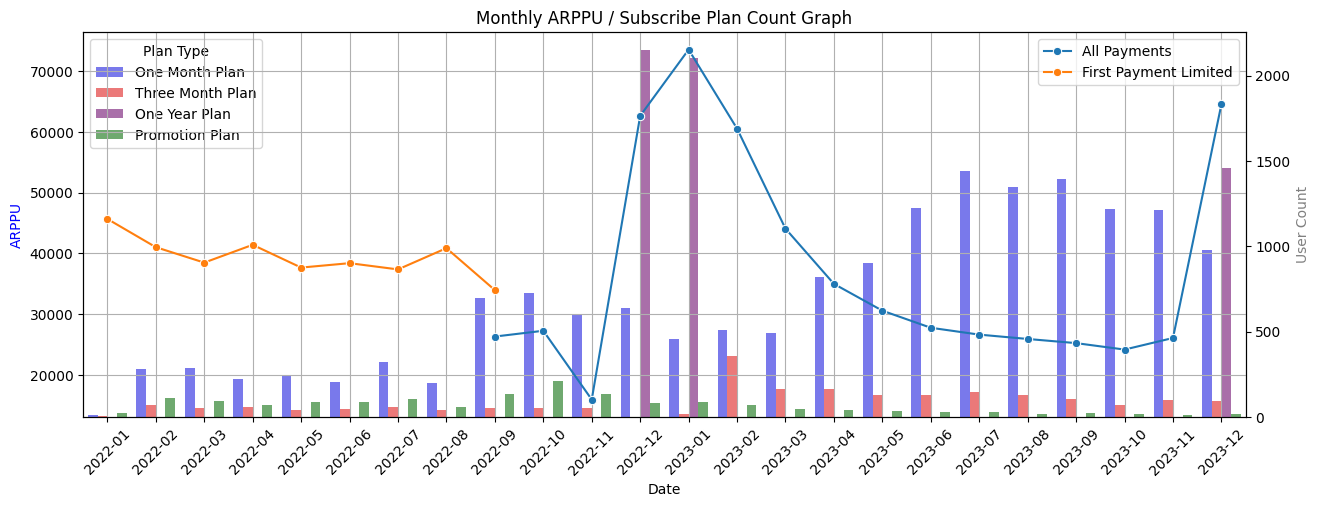

In [ ]:
# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 5))

# 라인 플롯
sns.lineplot(x=merged_df['period'], y=merged_df['ARPPU_df1'], marker='o', ax=ax1, label='All Payments')
sns.lineplot(x=merged_df['period'], y=merged_df['ARPPU_df2'], marker='o', ax=ax1, label='First Payment Limited')

# 바 플롯을 보조로 사용하기 위한 준비
ax2 = ax1.twinx()

# 색상 설정
plan_colors = {
    'one_month_plan_user': 'blue', 
    'three_month_plan_user': 'green', 
    'one_year_plan_user': 'red', 
    'promotion_plan_user': 'purple'
}

# 바 플롯 그리기 (색상 지정 및 alpha 조정)
sns.barplot(x='period', y='user_count', hue='plan_type', data=final_df, ax=ax2, alpha=0.6, palette=plan_colors)

# zorder 조정
ax1.set_zorder(3)
ax2.set_zorder(2)
ax1.grid(True, zorder=0)

# 라벨 및 제목 설정
ax1.set_xlabel('Date')
ax1.set_ylabel('ARPPU', color='b')
ax2.set_ylabel('User Count', color='gray')
plt.title('Monthly ARPPU / Subscribe Plan Count Graph')

# x축 회전
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# 투명하게 만들어서 grid가 보이도록 설정
ax1.patch.set_visible(False)

# 범례 수동으로 설정 (색상과 항목이 매칭되도록)
handles, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(handles=handles, labels=['One Month Plan', 'Three Month Plan', 'One Year Plan', 'Promotion Plan'], title='Plan Type', loc='upper left')

# 범례 최상단 배치
legend.set_zorder(4)  

plt.show()

In [89]:
merged_df

,period,total_paid_amount_df1,total_user_df1,one_month_plan_user_df1,three_month_plan_user_df1,one_year_plan_user_df1,promotion_plan_user_df1,ARPPU_df1,total_paid_amount_df2,total_user_df2,one_month_plan_user_df2,three_month_plan_user_df2,one_year_plan_user_df2,promotion_plan_user_df2,ARPPU_df2
0,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2673121.0,58.0,17.0,27.0,8.0,0.0,46088.29
1,2022-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21870573.0,533.0,282.0,113.0,67.0,0.0,41032.97
2,2022-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25206951.0,655.0,287.0,95.0,55.0,0.0,38483.89
3,2022-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23380741.0,562.0,226.0,67.0,58.0,0.0,41602.74
4,2022-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23643732.0,632.0,239.0,87.0,39.0,0.0,37410.97
5,2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23312867.0,601.0,205.0,89.0,49.0,0.0,38790.13
6,2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26508779.0,712.0,324.0,109.0,58.0,0.0,37231.43
7,2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16238462.0,396.0,200.0,57.0,40.0,0.0,41006.22
8,2022-09-01,24370509.0,928.0,671.0,128.0,48.0,0.0,26261.32,1654631.0,49.0,33.0,10.0,5.0,0.0,33767.98
9,2022-10-01,30166704.0,1104.0,721.0,216.0,53.0,0.0,27324.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
### ARPU 계산 전 데이터 전처리

start.free_trial, enter.lesson_page 데이터를 통한 무료체험 유저 데이터 필터링

In [7]:
# 기존 데이터에서 필요한 부분만 가져오기
concat_df_for_arpu = concat_df[['user_id', 'client_event_time', 'paid_amount']].reset_index(drop=True)

# period 컬럼에 필터링한 값 추기
concat_df_for_arpu['period'] = concat_df_for_arpu['client_event_time'].dt.to_period('M')

# 데이터 확인
concat_df_for_arpu

,user_id,client_event_time,paid_amount,period
0,1116a2ae90ca6b06f85feba27ad51ef0,2023-04-05 21:40:04.000,15920,2023-04
1,c0f5678df8967163e6e2c464ed006791,2023-04-10 14:20:03.008,131600,2023-04
2,79421b5d038205ad7adbb1e2c3b89741,2023-03-12 08:46:14.026,119756,2023-03
3,bdffe1f18684704d4ea2d7eebcaed180,2023-04-12 11:35:01.865,131600,2023-04
4,d4f54ecf6c4d7bf8742f80505f02d6dc,2023-05-31 01:25:55.820,15920,2023-05
...,...,...,...,...
31018,482cf2ed1eefbe648ce156e43d323114,2023-10-20 19:29:37.174,15920,2023-10
31019,b6b9428216580dbdc053e0bb19083be1,2023-07-31 03:01:55.489,15920,2023-07
31020,eaff98093acb9a109975957cafb2d105,2023-12-31 03:53:51.324,95520,2023-12
31021,e6aace24ed8703d42ce43c4b8b1c7d66,2023-12-29 13:33:42.128,95520,2023-12


In [8]:
# 데이터 불러오기
start_free_trial_df = start.free_trial()
enter_lesson_page_df = enter.lesson_page()

e:\Visual Studio Code\codeit\intermediate_project\datasets.py:132: DtypeWarning: Columns (9,13,15) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [12]:
# start.free_trial에서 필요한 컬럼 가져오기
start_free_trial_df_for_arpu = start_free_trial_df[['user_id', 'client_event_time']]

# 데이터 타입 변경
start_free_trial_df_for_arpu['client_event_time'] = pd.to_datetime(start_free_trial_df_for_arpu['client_event_time'])

# period를 통한 월별 데이터 컬럼 생성 및 값 추가
start_free_trial_df_for_arpu['period'] = start_free_trial_df_for_arpu['client_event_time'].dt.to_period('M')

# 데이터 추가
start_free_trial_df_for_arpu

C:\Users\lento\AppData\Local\Temp\ipykernel_21748\374240660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_free_trial_df_for_arpu['client_event_time'] = pd.to_datetime(start_free_trial_df_for_arpu['client_event_time'])
C:\Users\lento\AppData\Local\Temp\ipykernel_21748\374240660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_free_trial_df_for_arpu['period'] = start_free_trial_df_for_arpu['client_event_time'].dt.to_period('M')


,user_id,client_event_time,period
0,06b6868000a5d576180aca47896d6cce,2023-04-05 21:49:36.156,2023-04
1,40acc1ddfc012f3d2f58a3de95e9e748,2023-03-12 08:28:29.384,2023-03
2,38aca03fba9753a6b2f31b829fb16a30,2023-03-12 08:35:00.107,2023-03
3,cc8051a75f62278b0e4216dd0a182d8c,2023-04-12 11:36:50.250,2023-04
4,4cc436ad294973993ccad3e3a70053a7,2023-02-18 04:13:20.822,2023-02
...,...,...,...
30616,d4488d048e462d6c5b69e861d35dcc6b,2022-02-21 04:56:12.117,2022-02
30617,613273af4d4e1b57d6ab93e2bf76e017,2022-02-21 04:49:35.114,2022-02
30618,fd2b864d7f354eb48a29ff2ce78d229d,2022-02-21 04:37:53.294,2022-02
30619,a318b7d752a63d5d2302a4493835bc10,2022-02-21 04:13:10.443,2022-02


In [20]:
# 원본 데이터 중 is_trial이 null값이 아니고, True인 값 필터링
enter_lesson_page_df = enter_lesson_page_df[(enter_lesson_page_df['is_trial'].notnull()) & (enter_lesson_page_df['is_trial'] == True)]

# enter.lesson_page 내에서 필요한 데이터 컬럼 가져오기
enter_lesson_page_df_for_arpu = enter_lesson_page_df[['user_id', 'client_event_time']]

# 가져온 데이터 중 user_id 중복값 체크후 있을 경우 client_event_time값을 first로 가져오기
enter_lesson_page_df_for_arpu = enter_lesson_page_df_for_arpu.drop_duplicates(subset='user_id', keep='first')

# 데이터 타입 변결
enter_lesson_page_df_for_arpu['client_event_time'] = pd.to_datetime(enter_lesson_page_df_for_arpu['client_event_time'])

# start.free_trial 데이터셋의 수집 기간 중 수집하지 못한 데이터 기간을 필터링
enter_lesson_page_df_for_arpu = enter_lesson_page_df_for_arpu[enter_lesson_page_df_for_arpu['client_event_time'] > '2023-05-01']

# period를 통한 월별 데이터 컬럼 생성 및 값 추가
enter_lesson_page_df_for_arpu['period'] = enter_lesson_page_df_for_arpu['client_event_time'].dt.to_period('M')

# index 재정렬
enter_lesson_page_df_for_arpu = enter_lesson_page_df_for_arpu.reset_index(drop=True)

In [ ]:
enter_lesson_page_df_for_arpu

,user_id,client_event_time,period
0,08ebb0b2858b5a1bc1f496a29735c54b,2023-05-27 18:08:12.193,2023-05
1,cd682cfd3c7131dda66bc9206cf171b5,2023-05-31 01:54:21.117,2023-05
2,0dc9cb4e3ff658154422ae5ca8aa831c,2023-05-31 01:04:31.878,2023-05
3,4f2f2882464254309683a022c7693e93,2023-05-31 01:17:18.269,2023-05
4,9a4e7d394c37719487c1ddd947d4aae9,2023-06-18 18:24:33.589,2023-06
...,...,...,...
8041,ae801027f8f2b65ff4964f0dc6474ad1,2023-11-16 13:44:07.841,2023-11
8042,74ae79e4bba4872b1878c3c4143c9bff,2023-10-02 12:44:41.061,2023-10
8043,fd4885296199427c04cc03e0706c3783,2023-10-30 00:57:25.761,2023-10
8044,c7ecf95d4f1d4c5fae23384919752bb6,2023-10-30 00:09:20.463,2023-10


의존성 검사

In [26]:
print(len(set(concat_df_for_arpu['user_id']) & set(start_free_trial_df['user_id'])))
print(len(set(start_free_trial_df_for_arpu['user_id']) & set(enter_lesson_page_df_for_arpu['user_id'])))

3734
174


의존성 검사 결과
- enter.lesson_page에서 2023년 5월 1일부터 무료 레슨을 들은 사람 중 start.free_trial 테이블과 겹치는 데이터는 174개

궁금점
- enter.lesson_page는 lesson 페이지에 입장한 이벤트 로그이다.
- free_trial을 사용한 내역을 알 수 없는데 과연 이 데이터를 가지고 사용할 수 있는가?<br/>
    → enter.lesson_page와 complete.signup의 client_event_time의 중간값을 사용한다고 해결이 될 것 같지 않음. <br/>
    → 지금도 충분히 이 데이터로 ARPU를 측정하기엔 노이즈 요소라고 생각할 수 있는데 노이즈가 추가로 생기는 상황이 발생 <br/>

---
### 일단 분리

In [4]:
enter_main_page_df = enter.main_page()

In [4]:
# 비회원이 main_page에 접속한 빈도 상위 15개 OS 
enter_main_page_df[enter_main_page_df['user_id'].isnull()]['os_name'].value_counts().head(15)

os_name
Chrome             658242
Mobile Safari      224270
Instagram          198313
Samsung Browser    107053
Edge                87097
Chrome WebView      66835
Whale               66410
Chrome Mobile       48206
Safari              47874
WebKit              47631
Facebook            37220
GSA                 10788
Firefox              3870
Chrome Headless      2775
Opera                 973
Name: count, dtype: int64

In [5]:
# 국가별 main_page에 접속한 빈도 상위 15개 국가
enter_main_page_df['country'].value_counts().head(15)

country
South Korea       2079303
United States       18925
Japan                5329
Canada               4142
Germany              3009
Ireland              2144
Australia            1970
Singapore            1736
United Kingdom       1688
Vietnam              1317
India                1216
France               1014
Hong Kong             970
China                 784
Thailand              524
Name: count, dtype: int64

In [6]:
# 각 국가별 main_page에 접속한 OS 비율
enter_main_page_df.groupby

<bound method DataFrame.groupby of                   city           client_event_time      country  \
0          Seongnam-si  2023-04-05 21:55:06.140000  South Korea   
1        Dongdaemun-gu  2023-04-05 21:04:28.967000  South Korea   
2          Hwaseong-si  2023-04-05 21:01:31.258000  South Korea   
3          Hwaseong-si  2023-04-05 21:02:50.374000  South Korea   
4                Seoul  2023-04-05 21:30:33.727000  South Korea   
...                ...                         ...          ...   
2133543       Jeongeup  2023-10-10 05:53:29.283000  South Korea   
2133544       Jeongeup  2023-10-10 05:54:17.572000  South Korea   
2133545     Gangnam-gu  2023-10-10 05:54:33.164000  South Korea   
2133546        Saha-gu  2023-10-10 05:58:15.175000  South Korea   
2133547          Seoul  2023-10-10 05:58:45.857000  South Korea   

         device_carrier        device_family                device_type  \
0                   NaN        Samsung Phone      Samsung Galaxy S21 5G   
1         

In [2]:
enter_content_page_df = enter.content_page()
start_free_trial_df = start.free_trial()
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()
start_content_df = start.content()

In [96]:
# 모든 결제 완료 이력
concat_df = pd.concat([complete_subscription_df, renew_subscription_df, resubscribe_df], axis=0)
concat_df = concat_df.drop_duplicates()
concat_df

# data type 변경
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time'])

merge_df2 = pd.merge(concat_df, start_free_trial_df[['user_id', 'plan.type']], how='inner', on='user_id')
merge_df2 = merge_df2.drop_duplicates()
merge_df2.groupby(['plan.price', 'plan.type']).size().reset_index(name='count')

# 궁금점
concat_df.groupby('plan.price').agg(client_event_time_min=('client_event_time', 'min'), client_event_time_max=('client_event_time', 'max'))

,client_event_time_min,client_event_time_max
plan.price,,
14328,2023-05-02 07:50:46.978,2023-12-17 02:30:01.995
15920,2022-01-02 08:34:14.270,2023-12-31 09:20:02.770
19920,2023-03-16 01:59:11.035,2023-03-16 01:59:11.035
42960,2022-01-01 06:17:24.513,2023-12-30 09:20:05.551
79200,2022-11-30 15:11:19.442,2022-12-31 14:58:49.139
83200,2022-12-31 15:18:32.786,2023-01-10 14:59:10.551
87200,2023-01-10 15:04:31.960,2023-01-17 14:56:54.133
91200,2023-01-17 15:00:47.164,2023-01-24 14:58:37.499
95200,2023-01-24 15:00:07.569,2023-01-31 14:55:01.296


In [37]:
# 모든 결제 건 수 중 무료 체험을 시작한 후 결제한 유저의 값
merge_df = pd.merge(start_free_trial_df, concat_df, on='user_id', how='inner')
merge_df

,city_x,client_event_time_x,country_x,device_carrier_x,device_family_x,device_type_x,event_type_x,language_x,os_name_x,os_version_x,platform_x,user_id,plan.price_x,plan.type,trial.type,city_y,client_event_time_y,country_y,device_carrier_y,device_family_y,device_type_y,event_type_y,language_y,os_name_y,os_version_y,platform_y,plan.price_y,paid_amount,coupon.discount_amount,pg.type
0,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Seoul,2023-03-19 08:35:01.854000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,111.0.0.0,Web,15920,15920,0,NaN
1,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Seoul,2023-04-19 08:40:02.338,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,111.0.0.0,Web,15920,15920,0,NaN
2,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Suwon,2023-05-19 08:45:01.660,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,112.0.0.0,Web,15920,15920,0,NaN
3,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Guro-gu,2023-06-19 08:50:02.764,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,114.0.0.0,Web,15920,15920,0,NaN
4,NaN,2023-03-12 08:35:00.107000,NaN,NaN,NaN,NaN,start.free_trial,NaN,NaN,NaN,NaN,38aca03fba9753a6b2f31b829fb16a30,15920.0,1개월 플랜,B,Seoul,2023-07-19 08:55:01.945,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,114.0.0.0,Web,15920,15920,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14394,Hongseong-gun,2022-10-28 04:16:34.387000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,107.0,Web,3c55c67f1a2634bd2a38d4ee11daa650,NaN,NaN,A,Hongseong-gun,2022-11-04 04:20:02.926000,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,107,Web,131600,131600,0,NaN
14395,Hongseong-gun,2022-10-28 04:16:34.387000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,107.0,Web,3c55c67f1a2634bd2a38d4ee11daa650,NaN,NaN,A,Hongseong-gun,2022-11-04 04:20:01.516,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,107,Web,131600,131600,0,NaN
14396,Uiwang,2022-05-28 04:36:00.949000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,102.0,Web,4254765f174fe193cd90c093d73e62e8,NaN,NaN,A,Gwangmyeong,2022-05-31 05:14:36.838000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,101,Web,15920,13532,2388,NaN
14397,Uiwang,2022-05-28 04:36:32.423000,South Korea,NaN,Windows,Windows,start.free_trial,Korean,Chrome,102.0,Web,4254765f174fe193cd90c093d73e62e8,NaN,NaN,A,Gwangmyeong,2022-05-31 05:14:36.838000,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Chrome,101,Web,15920,13532,2388,NaN


In [3]:
# 데이터 불러오기
click_content_page_start_content_btn_df = click.content_page_start_content_button()

# 데이터 타입 변환
click_content_page_start_content_btn_df['client_event_time'] = pd.to_datetime(click_content_page_start_content_btn_df['client_event_time'])

# 데이터 분리
type_a_df = click_content_page_start_content_btn_df[
    click_content_page_start_content_btn_df['button.name'].isnull() &\
    click_content_page_start_content_btn_df['button_name'].notnull()]
type_b_df = click_content_page_start_content_btn_df[
    click_content_page_start_content_btn_df['button.name'].notnull() &\
    click_content_page_start_content_btn_df['button_name'].isnull()]

# 데이터 확인
print("Type A 날짜 범위")
print(type_a_df.groupby('button_name').agg(min_time=('client_event_time', 'min'), max_time=('client_event_time', 'max')))
print("\n")
print("Type B 날짜 범위")
print(type_b_df.groupby('button.name').agg(min_time=('client_event_time', 'min'), max_time=('client_event_time', 'max')))

NameError: name 'click' is not defined

In [49]:
complete_signup_df = complete.signup()
start_free_trial_df = start.free_trial()
start_content_df = start.content()

complete_subscription_df = complete.subscription()

In [ ]:
# signup 데이터와 free_trial 데이터 병합
merge_df1 = pd.merge(
    complete_signup_df[['user_id', 'client_event_time']],
    start_free_trial_df[['user_id', 'client_event_time']],
    how='left',
    on='user_id',
    suffixes=('_signup', '_free_trial')
)

# 이전에 병합한 데이터에 complete_subscription 데이터 병합
merge_df2 = pd.merge(
    merge_df1,
    complete_subscription_df[['user_id', 'client_event_time']],
    how='left',
    on='user_id'
)

# 이전에 병합한 데이터에 start_content 데이터 병합
merge_df3 = pd.merge(
    merge_df2,
    start_content_df[['user_id', 'client_event_time']],
    how='left',
    on='user_id')

# 중복값 제거
merge_df3 = merge_df3.drop_duplicates()

# 데이터 컬럼명 재정의
merge_df3.rename(columns={
    'client_event_time_signup': 'signup_time',
    'client_event_time_free_trial': 'free_trial_time',
    'client_event_time_x': 'subscription_time',
    'client_event_time_y': 'content_time'
}, inplace=True)

merge_df3

# user_id로 묶은 뒤 각 행들의 첫번째 값들만 뽑아오기
merge_groupby = merge_df3.groupby('user_id').agg({
    'signup_time' : 'first',
    'subscription_time' : 'first',
    'free_trial_time' : 'first',
    'content_time' : 'first'
})

merge_groupby = merge_groupby.reset_index()

merge_groupby # 145133 rows × 3 columns (수정 별도로 필요)

# content_time이 결측치인 값을 제거
merge_groupby.dropna(subset=['content_time']) # 36388 rows × 4 columns

merge_groupby

# # 활성화 무료 유저 : 36388명

,user_id,signup_time,subscription_time,free_trial_time,content_time
0,0000572f2ba8079bcefd2760b632e820,2023-03-18 10:33:16.237000,2023-03-25 14:40:01.647000,2023-03-18 14:39:22.844000,2023-03-18 16:49:45.361000
1,000087537cbfd934375364218ff10f91,2023-03-27 04:54:01.257000,2023-04-08 11:45:01.586000,2023-04-01 11:42:25.489000,2023-05-01 10:31:15.918000
2,000117267e1dd62481ef3ae7fb420107,2022-12-16 05:05:24.926000,None,None,None
3,0001f15911b404f3bf5b8571afafa4e4,2023-11-19 02:53:43.023000,2023-11-29 01:13:51.820000,None,2023-11-22 12:50:00.941000
4,0001f28a707789a7d78dc28fd2e84dce,2023-10-15 15:09:34.334000,None,None,None
...,...,...,...,...,...
145128,fffe529de03d6187ef7ed765650c8d2b,2023-02-26 13:40:51.953000,None,2023-03-01 12:37:09.512000,2023-05-02 08:10:35.470000
145129,fffee4d401b390a681491b9f5cfe40fb,2023-12-31 07:37:01.064000,None,None,None
145130,fffef868442fc8f4f405894b8ff8959f,2023-07-03 04:52:16.228000,None,None,None
145131,ffffd8d78865a66cb3706977f29d1dec,2023-09-11 10:06:34.388000,None,None,2023-11-15 04:45:32.896000


In [2]:
enter_main_page_df = enter.main_page()

In [3]:
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Windows'].shape[0])
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Mac'].shape[0])
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Linux'].shape[0])
print(enter_main_page_df[enter_main_page_df['device_type'] == 'Ubuntu'].shape[0])

845411
233654
16489
143


In [4]:
enter_main_page_df[(enter_main_page_df['device_family'].str.contains('-') == False) &
                   (enter_main_page_df['device_family'].str.contains('_') == False) &
                   (enter_main_page_df['device_family'].str.contains(r'\d') == False) &
                   (enter_main_page_df['device_family'].str.contains('Phone') == False) &
                   (enter_main_page_df['device_family'].str.contains('TV') == False) &
                   (enter_main_page_df['device_family'].str.contains('Tablet') == False) &
                   (enter_main_page_df['device_family'].str.contains('Mobile') == False) &
                   (enter_main_page_df['device_family'].str.contains('Android') == False) &
                   (enter_main_page_df['device_family'].str.contains('Samsung') == False) &
                   (enter_main_page_df['device_family'].str.contains('Apple') == False)]['device_family'].unique()

array(['Mac', 'Windows', 'Linux', 'K', 'CentOS', 'Chromium OS', 'Ubuntu',
       'LG lge', 'Tesla Linux', 'HiPad X', 'Microsoft Xbox One',
       'Xiaomi MID', 'wv', 'Fedora', 'AOSP on flame', 'iOS', 'Active',
       '<Device Model>', 'LG Linux', 'Amazon Kindle', 'DTABPLUS',
       'BISON GT', 'Microsoft Surface Duo', 'Titan', 'Tizen',
       'BlackBerry', 'BISON Pro', 'Sony Xperia', 'Motorola razr',
       'DEVICE INFO', 'walleye', 'tablePC', 'MASTERPRO', 'NovaAirC',
       'BRAVE'], dtype=object)

In [85]:
complete_signup_df = complete.signup()
start_free_trial_df = start.free_trial()
complete_subscription_df = complete.subscription()
renew_subscription_df = renew.subscription()
resubscribe_df = resubscribe.subscription()
cancel_plan_df = click.cancel_plan_button()

In [86]:
# 데이터 concat
concat_df = pd.concat([
    complete_signup_df[['user_id', 'client_event_time', 'event_type']],
    start_free_trial_df[['user_id', 'client_event_time', 'event_type']],
    complete_subscription_df[['user_id', 'client_event_time', 'event_type']],
    renew_subscription_df[['user_id', 'client_event_time', 'event_type']],
    resubscribe_df[['user_id', 'client_event_time', 'event_type']],
    cancel_plan_df[['user_id', 'client_event_time', 'event_type']]], axis=0).reset_index(drop=True)

# 데이터 타입 변경
concat_df['client_event_time'] = pd.to_datetime(concat_df['client_event_time']) + pd.DateOffset(hours=9)

# user_id 컬럼 결측치 제거
concat_df = concat_df.dropna(subset=['user_id'])

# 데이터 기한 설정
concat_df = concat_df[(concat_df['client_event_time'] >= '2022-01-01') & (concat_df['client_event_time'] < '2023-05-01')]

# client_event_time 오름차순 정렬
concat_df = concat_df.sort_values(by='client_event_time').reset_index(drop=True)

# 데이터 확인
concat_df

,user_id,client_event_time,event_type
0,6b4b4d8e08ce009f8992c546372ce664,2022-01-01 09:06:31.232,complete.signup
1,a5b72d5c6dd4e213315225d9fb9bbbca,2022-01-01 09:10:21.400,complete.signup
2,81c52556d0605b8221aa897cd2ed740d,2022-01-01 09:10:49.730,complete.signup
3,4a8e9325b1a855be259d7dad2d378276,2022-01-01 09:12:18.251,complete.signup
4,e98481d6081c560ad6c9c01c4596129e,2022-01-01 09:17:55.165,start.free_trial
...,...,...,...
148542,7ca10d40675592dbacde558dcebfb501,2023-04-30 23:48:54.989,complete.signup
148543,a01b3ae7f1817ebd60860f3fcd5e40c5,2023-04-30 23:51:16.178,complete.signup
148544,95cfd6728d7b510b5ad18e8e16fdc672,2023-04-30 23:55:01.850,complete.subscription
148545,cea0d65cbcd9005a6a4e66b5f39aa5e7,2023-04-30 23:56:40.414,start.free_trial


In [87]:
concat_df['user_id'].nunique()

96072

In [88]:
trial_list = []
non_trial_list = []

for user_id in concat_df['user_id'].unique():
    user_df = concat_df[concat_df['user_id'] == user_id]
    
    if 'complete.signup' in user_df['event_type'].values:
        if ('start.free_trial' in user_df['event_type'].values) & ('complete.subscription' in user_df['event_type'].values):
            trial_list.append(user_df)
        if ('start.free_trial' not in user_df['event_type'].values) & ('complete.subscription' in user_df['event_type'].values):
            non_trial_list.append(user_df)

# 최종 데이터 병합
trial_df = pd.concat(trial_list, ignore_index=True)
non_trial_df = pd.concat(non_trial_list, ignore_index=True)

In [89]:
trial_df['user_id'].nunique()

3015

In [90]:
# 무료체험을 하고 구독한 유저의 타임라인 데이터프레임 작업란
resubs_time_list1 = []
cancel_time_list1 = []

for user_id in trial_df['user_id'].unique():
    user_df = trial_df[trial_df['user_id'] == user_id]
    
    # resubscribe.subscription 계산
    if 'resubscribe.subscription' in user_df['event_type'].values:
        user_df = user_df.sort_values(by='client_event_time')  # 시간 순 정렬
        user_df['prev_client_event_time'] = user_df['client_event_time'].shift(1)  # 이전 이벤트 시간 추가
        
        resubs_time = user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'client_event_time'] - \
                      user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'prev_client_event_time']
        
        # NaN 값 제거 후 리스트에 추가
        resubs_time_list1.extend(resubs_time.dt.days.dropna().tolist())

    # click.cancel_plan_button 계산
    if 'click.cancel_plan_button' in user_df['event_type'].values and 'complete.signup' in user_df['event_type'].values:
        signup_time = user_df.loc[user_df['event_type'] == 'complete.signup', 'client_event_time'].min()  # 첫 구독 시간
        cancel_times = user_df.loc[user_df['event_type'] == 'click.cancel_plan_button', 'client_event_time']
        
        cancel_time_diff = (cancel_times - signup_time).dt.days.dropna()
        cancel_time_list1.extend(cancel_time_diff.tolist())

# 평균 계산 (0으로 나누는 경우 방지)
avg_resubs_time1 = sum(resubs_time_list1) / len(resubs_time_list1) if resubs_time_list1 else 0
avg_cancel_time1 = sum(cancel_time_list1) / len(cancel_time_list1) if cancel_time_list1 else 0

In [91]:
print(f"무료 체험을 한 유저의 수 : {trial_df['user_id'].nunique()}명")
print(f"그 중 만료 뒤 재구독을 한 유저의 수 : {trial_df[trial_df['event_type'] == 'resubscribe.subscription']['user_id'].nunique()}명")
print(f"그 중 구독을 취소한 유저의 수 : {trial_df[trial_df['event_type'] == 'click.cancel_plan_button']['user_id'].nunique()}명")
print(f"평균 만료 후 재 구독 경과 시간 : {avg_resubs_time1:.2f}일")
print(f"취소 시 첫 구독 이래 이용한 평균 시간 : {avg_cancel_time1:.2f}일")

무료 체험을 한 유저의 수 : 3015명
그 중 만료 뒤 재구독을 한 유저의 수 : 36명
그 중 구독을 취소한 유저의 수 : 1868명
평균 만료 후 재 구독 경과 시간 : 110.36일
취소 시 첫 구독 이래 이용한 평균 시간 : 88.92일


In [92]:
non_trial_df['user_id'].nunique()

4928

In [93]:
# 무료체험을 하지 않고 구독한 유저의 타임라인 데이터프레임 작업란
resubs_time_list2 = []
cancel_time_list2 = []

for user_id in non_trial_df['user_id'].unique():
    user_df = non_trial_df[non_trial_df['user_id'] == user_id].copy()
    
    # resubscribe.subscription 계산
    if 'resubscribe.subscription' in user_df['event_type'].values:
        user_df = user_df.sort_values(by='client_event_time')  # 시간 순 정렬
        user_df['prev_client_event_time'] = user_df['client_event_time'].shift(1)  # 이전 이벤트 시간 추가
        
        resubs_time = user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'client_event_time'] - \
                      user_df.loc[user_df['event_type'] == 'resubscribe.subscription', 'prev_client_event_time']
        
        # NaN 값 제거 후 리스트에 추가
        resubs_time_list2.extend(resubs_time.dt.days.dropna().tolist())

    # click.cancel_plan_button 계산
    if 'click.cancel_plan_button' in user_df['event_type'].values and 'complete.signup' in user_df['event_type'].values:
        signup_time = user_df.loc[user_df['event_type'] == 'complete.signup', 'client_event_time'].min()  # 첫 구독 시간
        cancel_times = user_df.loc[user_df['event_type'] == 'click.cancel_plan_button', 'client_event_time']
        
        cancel_time_diff = (cancel_times - signup_time).dt.days.dropna()
        cancel_time_list2.extend(cancel_time_diff.tolist())

# 평균 계산 (0으로 나누는 경우 방지)
avg_resubs_time2 = sum(resubs_time_list2) / len(resubs_time_list2) if resubs_time_list2 else 0
avg_cancel_time2 = sum(cancel_time_list2) / len(cancel_time_list2) if cancel_time_list2 else 0

In [94]:
print(f"무료 체험을 한 유저의 수 : {non_trial_df['user_id'].nunique()}명")
print(f"그 중 만료 뒤 재구독을 한 유저의 수 : {non_trial_df[non_trial_df['event_type'] == 'resubscribe.subscription']['user_id'].nunique()}명")
print(f"그 중 구독을 취소한 유저의 수 : {non_trial_df[non_trial_df['event_type'] == 'click.cancel_plan_button']['user_id'].nunique()}명")
print(f"평균 만료 후 재 구독 경과 시간 : {avg_resubs_time2:.2f}일")
print(f"취소 시 첫 구독 이래 이용한 평균 시간 : {avg_cancel_time2:.2f}일")

무료 체험을 한 유저의 수 : 4928명
그 중 만료 뒤 재구독을 한 유저의 수 : 41명
그 중 구독을 취소한 유저의 수 : 2320명
평균 만료 후 재 구독 경과 시간 : 98.62일
취소 시 첫 구독 이래 이용한 평균 시간 : 77.28일


In [47]:
enter_main_page_df = enter.main_page()

In [50]:
class desktop_mobile_filter: 
    def __init__(self, class_name):
        self.class_name = class_name
    
    @staticmethod
    def desktop(data):
        desktop_columns = ((data['device_family'].str.contains('Windows')) | (data['device_family'].str.contains('Mac')))
        return desktop_columns
    
    @staticmethod
    def mobile(data):
        mobile_columns = ((data['device_family'].str.contains('Samsung')) |
                          (data['device_family'].str.contains('LG')) |
                          (data['device_family'].str.contains('Apple')) |
                          (data['device_family'] == 'Android') |
                          (data['device_family'] == 'iOS'))
        return mobile_columns

In [51]:
enter_main_page_df[desktop_mobile_filter.desktop(enter_main_page_df)]

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
1,Dongdaemun-gu,2023-04-05 21:04:28.967000,South Korea,NaN,Mac,Mac,enter.main_page,Korean,Chrome,111.0.0.0,Web,b2b31f00b82edc6419b25324a7ae41a4
8,Jung-gu,2023-04-05 21:55:29.031000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
14,Wonju,2023-04-05 21:44:18.121000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
15,Seoul,2023-04-05 21:44:50.470000,South Korea,NaN,Mac,Mac,enter.main_page,Korean,Safari,15.6.1,Web,NaN
18,Naju,2023-04-05 21:50:39.168000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Firefox,111.0,Web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2133540,Dongjak-gu,2023-10-10 05:57:19.646000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Edge,117.0.2045.60,Web,NaN
2133543,Jeongeup,2023-10-10 05:53:29.283000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,117.0.0.0,Web,NaN
2133544,Jeongeup,2023-10-10 05:54:17.572000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,117.0.0.0,Web,NaN
2133545,Gangnam-gu,2023-10-10 05:54:33.164000,South Korea,NaN,Windows,Windows,enter.main_page,Korean,Chrome,117.0.0.0,Web,NaN


In [52]:
enter_main_page_df[desktop_mobile_filter.mobile(enter_main_page_df)]

,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id
0,Seongnam-si,2023-04-05 21:55:06.140000,South Korea,NaN,Samsung Phone,Samsung Galaxy S21 5G,enter.main_page,Korean,Whale,1.0.0.0,Web,NaN
2,Hwaseong-si,2023-04-05 21:01:31.258000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
3,Hwaseong-si,2023-04-05 21:02:50.374000,South Korea,NaN,Samsung Galaxy Note,Samsung Galaxy Note10+ 5G,enter.main_page,Korean,Chrome,111.0.0.0,Web,NaN
4,Seoul,2023-04-05 21:30:33.727000,South Korea,NaN,Samsung Phone,Samsung Galaxy A51 5G,enter.main_page,Korean,Chrome,112.0.0.0,Web,NaN
5,Sejong,2023-04-05 21:36:02.749000,South Korea,NaN,Apple iPhone,Apple iPhone 12 Mini,enter.main_page,Korean,Instagram,276.1.0.14.103,Web,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2133537,Busan,2023-10-10 05:42:21.060000,South Korea,NaN,Samsung Phone,Samsung Galaxy S23 Ultra,enter.main_page,Korean,Instagram,303.0.0.40.109,Web,NaN
2133538,Seoul,2023-10-10 05:45:14.703000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,16.6,Web,NaN
2133541,Seoul,2023-10-10 05:54:19.608000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,17.0.1,Web,NaN
2133542,Seoul,2023-10-10 05:54:44.015000,South Korea,NaN,Apple iPhone,Apple iPhone,enter.main_page,Korean,Mobile Safari,17.0.1,Web,NaN


In [ ]:
enter_main_page_df[~((desktop_mobile_filter.desktop(enter_main_page_df) | (desktop_mobile_filter.mobile(enter_main_page_df))))]['device_family'].value_counts().head(15)

device_family
K                     41600
Linux                 16489
Xiaomi Phone           1799
Chromium OS            1269
CentOS                  733
Redmi Phone             657
Google Nexus Phone      635
Google Phone            231
Motorola Phone          153
Ubuntu                  143
Lenovo TB-J606F         128
2201116SG                92
Google Pixel 7a          85
M2101K7AG                84
Oppo Phone               81
Name: count, dtype: int64